# Support Vector Machine

In [1]:
# Loading modules required for data manipulation an EDA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Loading modules required for modelling
from sklearn.svm import SVR                             # To access the Support-vector regresssor
from sklearn.model_selection import KFold               # To create training/testing sets
from sklearn.model_selection import GridSearchCV        # To creat a tuning grid for hyperparameters
from sklearn.decomposition import PCA                   # Feature selection tool
from sklearn.pipeline import make_pipeline              # Lets us build a pipeline

# Loading modules to assess error
from sklearn.metrics import mean_squared_error          # To measure the mean of residual errors 
from sklearn.metrics import r2_score                    # To measure the accuracy of the fit

# loading modules to assess model
from sklearn.model_selection import cross_val_score     # To determine the model's cross validation accuracy scores
from sklearn.metrics import accuracy_score              # To determine the model's accuracy
from sklearn.dummy import DummyRegressor                # To create a regressor baseline

# Loading modules to plot confusion matrix
import matplotlib.pyplot as plt                         # This one
import seaborn as sns                                   # ... and this one are used to create figure objects
from sklearn.metrics import confusion_matrix            # To create confusion matrix
%matplotlib inline

In [2]:
# Importing Data
features = pd.read_csv('X.csv')
target = pd.read_csv('y.csv')

## Data Segregation
Splitting the data into 5 folds (80/20 split) and eabling reproducibility

In [3]:
# Creating numpy arrays of data to get k-folds 
X = np.array(features)
y = np.array(target)
kf = KFold(n_splits = 5, random_state = 42, shuffle =True)
print('Number of splits: ', kf.get_n_splits(X))

# Assigning the training and testing sets data based on the splits
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

# Returning array back to Dataframe
X_train = pd.DataFrame(X_train)
y_train = pd.DataFrame(y_train)
X_test = pd.DataFrame(X_test)
y_test = pd.DataFrame(y_test)

# Assessing sets
print('Dataset shapes: ', features.shape, "and ", target.shape)
print('Training set shape: ', X_train.shape, "and", y_train.shape)
print('Testing set shape: ', X_test.shape, "and ", y_test.shape)

Number of splits:  5
Dataset shapes:  (822, 30) and  (822, 1)
Training set shape:  (658, 30) and (658, 1)
Testing set shape:  (164, 30) and  (164, 1)


### Creating Baseline
Using the two from the course

In [11]:
# Creating naive baseline to compare with
baseline = np.mean(y_train.iloc[:, 0].to_numpy())
y_baseline = np.repeat(baseline, len(y_test.iloc[:, 0].to_numpy()))
naive_MSE = mean_squared_error(y_test, y_baseline)
naive_RMSE = np.sqrt(naive_MSE)
naive_rr = r2_score(y_test, y_baseline)

# Creating a DummyRegressor baseline
dummy_mean = DummyRegressor(strategy = 'mean').fit(X_train, y_train)
y_predict_dummy_mean = dummy_mean.predict(X_test)
dummy_MSE = mean_squared_error(y_test, y_predict_dummy_mean)
dummy_RMSE = np.sqrt(dummy_MSE)
dummy_rr = r2_score(y_test, y_predict_dummy_mean)

## Model Trainning
Deviating from the default slightly by using the linear 'kernel' and increasin C from 1 to 100.

In [5]:
# Building the model
model_svr = SVR(kernel = 'linear', C = 100)    

In [6]:
# Trainning the model on training data
model_svr.fit(X_train, y_train.iloc[:, 0].to_numpy())
print("Parameters passed to train model: \n", model_svr.get_params())

Parameters passed to train model: 
 {'C': 100, 'cache_size': 200, 'coef0': 0.0, 'degree': 3, 'epsilon': 0.1, 'gamma': 'scale', 'kernel': 'linear', 'max_iter': -1, 'shrinking': True, 'tol': 0.001, 'verbose': False}


In [7]:
# Testing the model on training and on testing sets
preds_train_untuned_svr = model_svr.predict(X_train)
preds_test_untuned_svr = model_svr.predict(X_test)

# Determining Cross validation scores
def average(lst):
    return sum(lst) / len(lst)
score_untuned_svr = cross_val_score(model_svr, features, target.iloc[:, 0].to_numpy(), cv = 5)
print("Cross Validation scores (untuned): ", score_untuned_svr, "\nCV score = ", average(score_untuned_svr)) 

# Measuring MSE
MSE_training_preds = mean_squared_error(y_train, preds_train_untuned_svr)
MSE_testing_preds = mean_squared_error(y_test, preds_test_untuned_svr)

# Measuring RMSE
RMSE_training_preds = np.sqrt(MSE_training_preds)
RMSE_testing_preds = np.sqrt(MSE_testing_preds)

# Measuring R-squared
rsq_training_preds = r2_score(y_train, preds_train_untuned_svr)
rsq_testing_preds = r2_score(y_test, preds_test_untuned_svr)


scores = {'Test':  ['Naive Baseline', 'Dummy Baseline', 'SVR on Training', 'SVR on Testing'],
          'MSE': [round(naive_MSE, 5), round(dummy_MSE, 5), round(MSE_training_preds, 5), round(MSE_testing_preds, 5)],
          'RMSE': [round(naive_RMSE, 5), round(dummy_RMSE, 5), round(RMSE_training_preds, 5), round(RMSE_testing_preds, 5)],
          'R-squared': [round(naive_rr, 5), round(dummy_rr, 5), round(rsq_training_preds, 5), round(rsq_testing_preds, 5)]
        }

scores_df = pd.DataFrame(scores)
print("\nHere are some performace metrics associated with the mean baseline and the untuned model:")
scores_df.head()

Cross Validation scores (untuned):  [0.84925756 0.51829923 0.77757214 0.82267965 0.78882086] 
CV score =  0.7513258905990029

Here are some performace metrics associated with the mean baseline and the untuned model:


,Test,MSE,RMSE,R-squared
0,Naive Baseline,0.02372,0.15403,-0.00029
1,Dummy Baseline,0.02372,0.15403,-0.00029
2,SVR on Training,0.00390,0.06249,0.83615
3,SVR on Testing,0.00453,0.06733,0.80885


## Model Tuning 

In [8]:
# Hyperparameters to calibrate 
param_grid = {'C': [1, 10, 50, 100], # 200 was taking too long
              'gamma': [ 0.01, 0.1, 0.9, 'scale'], # 0.0001, 0.001, taking days 
              'epsilon': [0.001, 0.01, 1], 
              'kernel' : ['linear']} # 'rbf', 'poly' were too time costly, 

# Hyperparameters to calibrate 
tuned_svr = GridSearchCV(model_svr, param_grid, cv = 5)

In [28]:
# Training the tuned model on training data
#tuned_svr = tuned_svr.fit(X_train, y_train.iloc[:, 0].to_numpy())
print(tuned_svr.best_params_)

# Testing the model on training set and on testing set
preds_train_tuned_svr = tuned_svr.predict(X_train)
preds_test_tuned_svr = tuned_svr.predict(X_test)

# Determining Cross validation scores
score_tuned_svr = cross_val_score(tuned_svr, features, target.iloc[:, 0].to_numpy(), cv = 5)
print("Cross Validation scores (tuned): ", score_tuned_svr, "\nCV score = ", average(score_tuned_svr)) 

# Measuring MSE 
MSE_training_preds = mean_squared_error(y_train, preds_train_tuned_svr)
MSE_testing_preds = mean_squared_error(y_test, preds_test_tuned_svr)

# Measuring RMSE 
RMSE_training_preds = np.sqrt(MSE_training_preds)
RMSE_testing_preds = np.sqrt(MSE_testing_preds)

# Measuring R-squared
rsq_training_preds = r2_score(y_train, preds_train_tuned_svr)
rsq_testing_preds = r2_score(y_test, preds_test_tuned_svr)


scores = {'Test':  ['Naive Baseline', 'Dummy Baseline', 'SVR on Training', 'SVR on Testing'],
          'MSE': [round(naive_MSE, 5), round(dummy_MSE, 5), round(MSE_training_preds, 5), round(MSE_testing_preds, 5)],
          'RMSE': [round(naive_RMSE, 5), round(dummy_RMSE, 5), round(RMSE_training_preds, 5), round(RMSE_testing_preds, 5)],
          'R-squared': [round(naive_rr, 5), round(dummy_rr, 5), round(rsq_training_preds, 5), round(rsq_testing_preds, 5)]
        }

scores_df = pd.DataFrame(scores)
print("\nHere are some performace metrics associated with the mean baseline and the tuned model:")
scores_df.head()

{'C': 100, 'epsilon': 0.001, 'gamma': 0.01, 'kernel': 'linear'}
Cross Validation scores (tuned):  [0.85538156 0.65150101 0.82817304 0.86258075 0.73680423] 
CV score =  0.7868881186249002

Here are some performace metrics associated with the mean baseline and the tuned model:


,Test,MSE,RMSE,R-squared
0,Naive Baseline,0.02372,0.15403,-0.00029
1,Dummy Baseline,0.02372,0.15403,-0.00029
2,SVR on Training,0.00352,0.05929,0.85246
3,SVR on Testing,0.00365,0.06038,0.84629


In [ ]:
# Creating model with feature selection (PCA)
pca = PCA(whiten = True,                                # Using uncorrelated components
          random_state = 42)                            # Setting a seed

model_pca_svr = make_pipeline(pca, tuned_svr)

# Tuning model
param_svr = { 'pca__n_components': [#5, 10, 15, 20, 25, tested all these, just making sure 30 components truly was the best
                29, 30],
            } # 30 indicates no reduction

tuned_svr_pca = GridSearchCV(model_pca_svr, param_svr, cv = 5)

# Trainning model on training data
tuned_svr_pca = tuned_svr_pca.fit(X_train, y_train.iloc[:, 0].to_numpy())
print(tuned_svr_pca.best_params_)

# Testing model on training and testing set
pca_train_tuned_prediction = tuned_svr_pca.predict(X_train)
pca_test_tuned_prediction = tuned_svr_pca.predict(X_test)

# Determining Cross validation scores
#score_tuned_svr_pca = cross_val_score(tuned_svr_pca, features, target.iloc[:, 0].to_numpy(), cv = 5)
#print("Cross Validation scores (tuned): ", score_tuned_svr_pca, "\nCV score = ", average(score_tuned_svr_pca)) 

# Measuring MSE 
MSE_training_preds_pca = mean_squared_error(y_train, pca_train_tuned_prediction)
MSE_testing_preds_pca = mean_squared_error(y_test, pca_test_tuned_prediction)

# Measuring RMSE 
RMSE_training_preds_pca = np.sqrt(MSE_training_preds_pca)
RMSE_testing_preds_pca = np.sqrt(MSE_testing_preds_pca)

# Measuring R-squared
rsq_training_preds = r2_score(y_train, pca_train_tuned_prediction)
rsq_testing_preds = r2_score(y_test, pca_test_tuned_prediction)


scores = {'Test':  ['Naive Baseline', 'Dummy Baseline', 'SVR on Training', 'SVR on Testing'],
          'MSE': [round(naive_MSE, 5), round(dummy_MSE, 5), round(MSE_training_preds, 5), round(MSE_testing_preds, 5)],
          'RMSE': [round(naive_RMSE, 5), round(dummy_RSME, 5), round(RMSE_training_preds, 5), round(RMSE_testing_preds, 5)],
          'R-squared': [round(naive_rr, 5), round(dummy_rr, 5), round(rsq_training_preds, 5), round(rsq_testing_preds, 5)]
        }

scores_df = pd.DataFrame(scores)
print("\nHere are some performace metrics associated with the mean baseline and the PCA/tuned model:")
scores_df.head()

In [23]:
# I stupidly decided to rerun this.tried to rerun this at 9:00 am the morning this was due and it was getting too close for comfort. 
# But it used 30 components and gave the output below.


Here are some performace metrics associated with the mean baseline and the PCA/tuned model:


,Test,MSE,RMSE,R-squared
0,Naive Baseline,0.02372,0.15403,-0.00029
1,Dummy Baseline,0.02372,0.15403,-0.00029
2,SVR on Training,0.00352,0.05929,0.85317
3,SVR on Testing,0.00365,0.06038,0.84719


Text(0, 0.5, 'Fitted values')

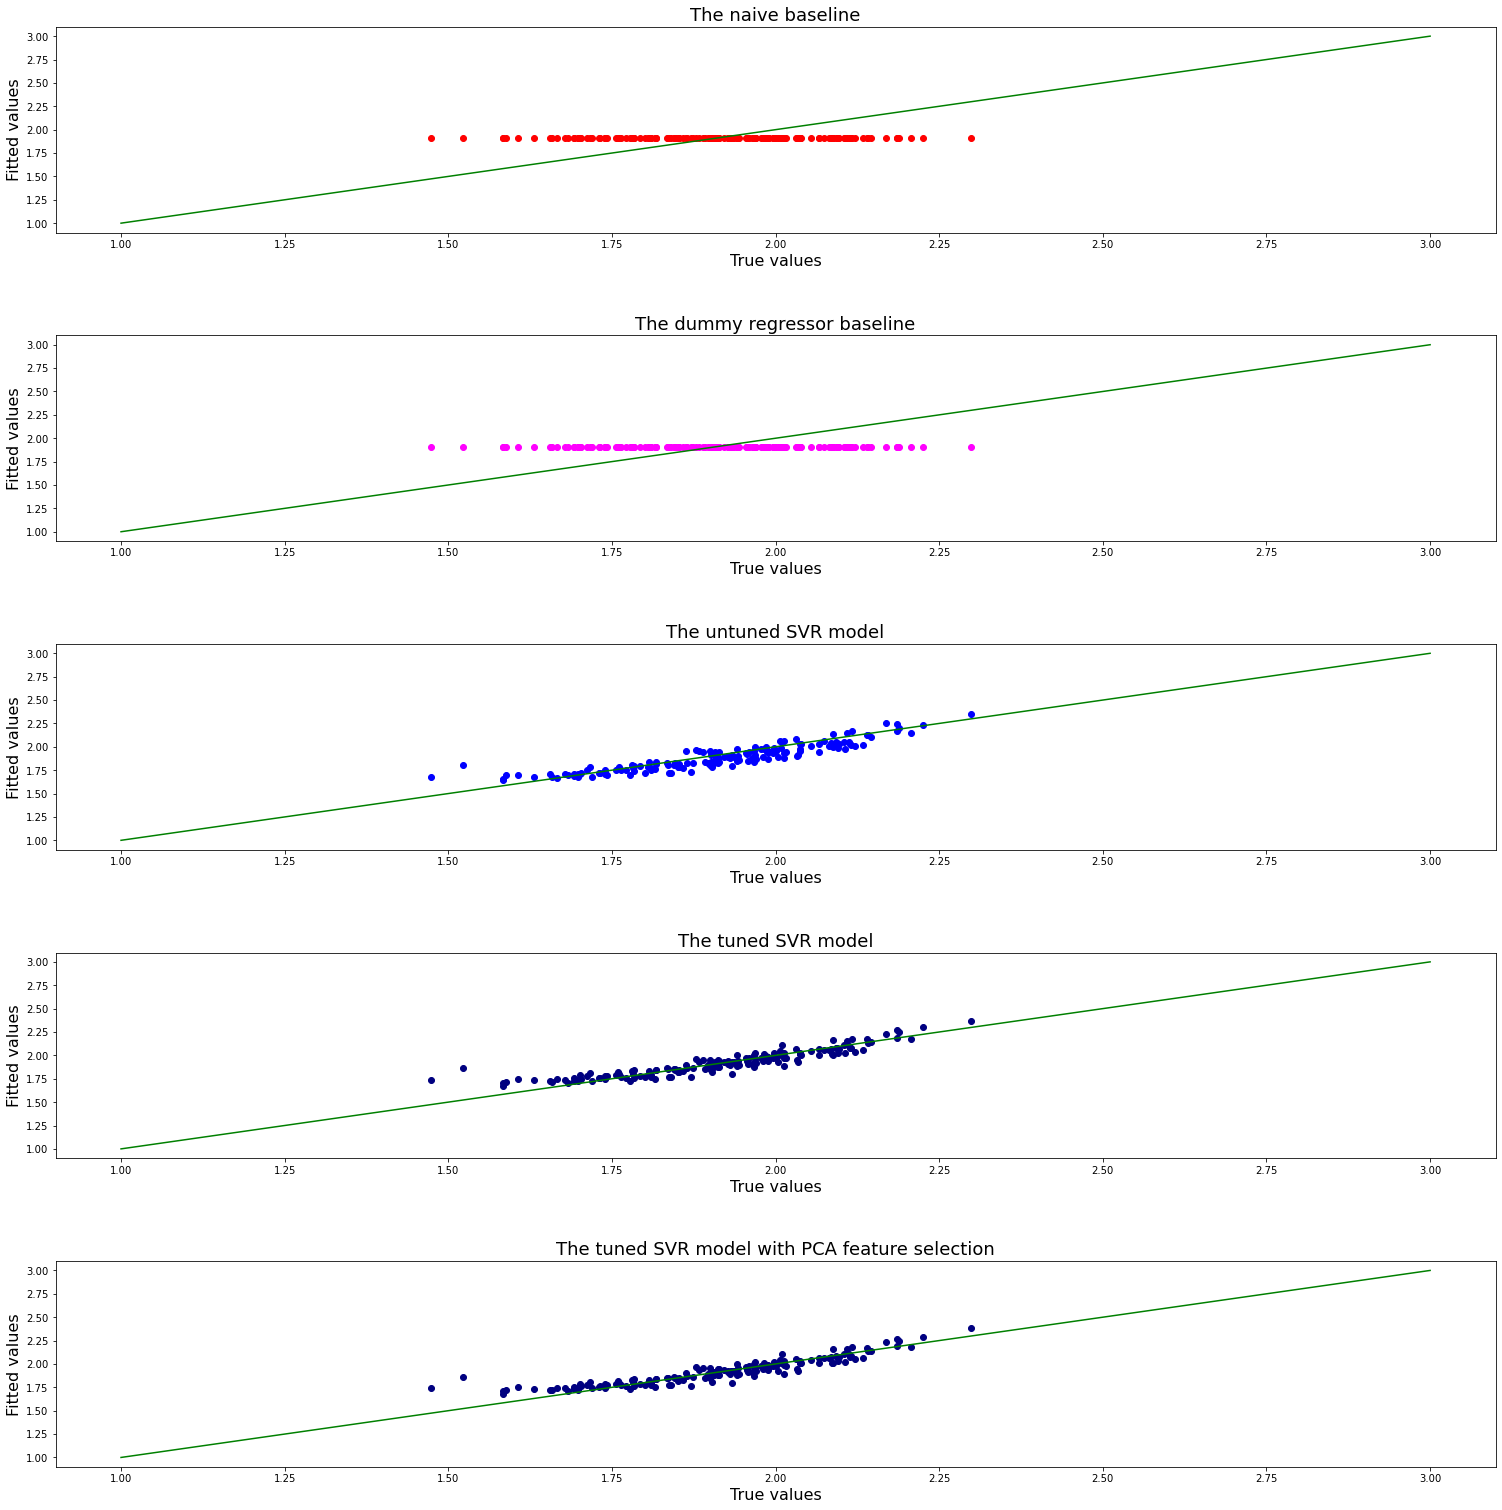

In [17]:
fig = plt.figure(figsize = (20,20))
fig.subplots_adjust( left = 0, right = 1, bottom = 0, top = 1, hspace =0.5, wspace = 0.5)

ax = fig.add_subplot(5,1, 1)
plt.scatter(y_test, y_baseline, color = 'red')
plt.plot(range(1,4), range(1,4),  color = 'green')
plt.title("The naive baseline", fontsize=18)
plt.xlabel('True values', fontsize = 16)
plt.ylabel('Fitted values', fontsize = 16)

ax = fig.add_subplot(5,1, 2)
plt.scatter(y_test, y_predict_dummy_mean, color = 'magenta')
plt.plot(range(1,4), range(1,4),  color = 'green')
plt.title("The dummy regressor baseline", fontsize=18)
plt.xlabel('True values', fontsize = 16)
plt.ylabel('Fitted values', fontsize = 16)


ax = fig.add_subplot(5,1, 3)
plt.scatter(y_test, preds_test_untuned_svr, color = 'blue')
plt.plot(range(1,4), range(1,4),  color = 'green')
plt.title("The untuned SVR model", fontsize=18)
plt.xlabel('True values', fontsize = 16)
plt.ylabel('Fitted values', fontsize = 16)

ax = fig.add_subplot(5,1, 4)
plt.scatter(y_test, preds_test_tuned_svr, color = 'navy')
plt.plot(range(1,4), range(1,4),  color = 'green')
plt.title("The tuned SVR model", fontsize=18)
plt.xlabel('True values', fontsize = 16)
plt.ylabel('Fitted values', fontsize = 16)

ax = fig.add_subplot(5,1, 5)
plt.scatter(y_test, pca_test_tuned_prediction, color = 'navy')
plt.plot(range(1,4), range(1,4),  color = 'green')
plt.title("The tuned SVR model with PCA feature selection", fontsize=18)
plt.xlabel('True values', fontsize = 16)
plt.ylabel('Fitted values', fontsize = 16)